In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import math
import glob
import pickle
import statistics
import scipy.stats as stats
from sklearn.neighbors import KernelDensity
import dask
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def getrange(numbers):
    return max(numbers) - min(numbers)

In [3]:
def get_files():
    models = glob.glob("/terra/data/cmip5/global/historical/*")
    avail={}
    for model in models:
        zg = glob.glob(str(model)+"/r1i1p1/day/native/zg*")
        try:
            test = zg[0]
            avail[model.split('/')[-1]] = zg
        except:
             pass
    return avail

In [4]:
files = get_files()
files['NOAA'] = glob.glob("/terra/data/reanalysis/global/reanalysis/NOAA/20thC/r1/day/native/z_day*")
files['ERA5'] = glob.glob("/terra/data/reanalysis/global/reanalysis/ECMWF/ERA5/6hr/native/zg*")

In [5]:
results={}
for model in files.keys():
    print(model)
    x = xr.open_mfdataset(files[model])
    if model == 'NOAA':
        x = x.rename({'hgt':'zg'})
        x = x.rename({'level':'plev'})
        x = x.sel(plev=850)
        x = x.sel(time=slice('1950','2005'))
    elif model == 'ERA5':
        x = x.rename({'latitude':'lat'})
        x = x.rename({'longitude':'lon'})
        x = x.rename({'level':'plev'})
        x = x.sel(plev=850)
        x = x.sel(time=slice('1979','2005'))
    else:
        x = x.sel(plev=85000)
        x = x.sel(time=slice('1950','2005'))
        x = x.load()
    if model == 'ERA5':
        x = x.sel(lat=slice(0,-60))
    else:
        x = x.sel(lat=slice(-60,0))
    x = x[['zg']]
    x = x.assign_coords(lon=(((x.lon + 180) % 360) - 180))
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        x = x.sortby(x.lon)
    x = x.sel(lon=slice(-50,20))
    x = x.resample(time="QS-DEC").mean(dim="time",skipna=True)
    x = x.load()
    x['maxi']=x.zg
    for i in range(len(x.time)):
        x.maxi[i] = x.zg[i].where((x.zg[i]==np.max(x.zg[i])))
    east=[]
    south=[]
    pres=[]
    for i in range(len(x.time)):
        ids =  np.argwhere(~np.isnan(x.maxi[i].values))
        latsid = [item[0] for item in ids]
        lonsid = [item[1] for item in ids]
        east.append(x.lon.values[np.max(lonsid)])
        south.append(x.lat.values[np.max(latsid)])
        pres.append(x.maxi.values[i][np.max(latsid)][np.max(lonsid)])
    results[model]=pd.DataFrame(np.array([x.time.values,east,south,pres]).T,columns=['time','east','south','pres'])
    x.close()

IPSL-CM5A-LR
MPI-ESM-MR
MRI-ESM1
MIROC-ESM-CHEM
EC-EARTH
HadGEM2-CC
bcc-csm1-1-m
FGOALS-g2
ACCESS1-0
MIROC-ESM
GFDL-CM3
CanESM2
IPSL-CM5B-LR
MPI-ESM-LR
CMCC-CM
GFDL-ESM2G
MIROC5
MPI-ESM-P


/home/pmarsh/.local/lib/python3.8/site-packages/xarray/coding/times.py:119: SerializationWarning: Ambiguous reference date string: 850-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0850-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/pmarsh/.local/lib/python3.8/site-packages/xarray/coding/times.py:119: SerializationWarning: Ambiguous reference date string: 850-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0850-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


CMCC-CMS
CNRM-CM5
IPSL-CM5A-MR
ACCESS1-3
MRI-CGCM3
bcc-csm1-1
CMCC-CESM
HadGEM2-AO
BNU-ESM
NorESM1-M
HadCM3
GFDL-ESM2M
NOAA
ERA5


In [6]:
for model in results:
    l = len(results[model])
    bottom = results[model].south.mean() - 3*(results[model].south.std())
    top = results[model].south.mean() + 3*(results[model].south.std())
    bottom_e = results[model].east.mean() - 3*(results[model].east.std())
    top_e = results[model].east.mean() + 3*(results[model].east.std())
    results[model] = results[model].where((results[model].south > bottom) & (results[model].south<top))
    results[model] = results[model].where((results[model].east > bottom_e) & (results[model].east < top_e)).dropna()
    print(model,l-len(results[model]))

IPSL-CM5A-LR 0
MPI-ESM-MR 0
MRI-ESM1 1
MIROC-ESM-CHEM 1
EC-EARTH 0
HadGEM2-CC 8
bcc-csm1-1-m 0
FGOALS-g2 0
ACCESS1-0 6
MIROC-ESM 225
GFDL-CM3 1
CanESM2 0
IPSL-CM5B-LR 0
MPI-ESM-LR 0
CMCC-CM 1
GFDL-ESM2G 5
MIROC5 0
MPI-ESM-P 0
CMCC-CMS 2
CNRM-CM5 0
IPSL-CM5A-MR 0
ACCESS1-3 1
MRI-CGCM3 2
bcc-csm1-1 3
CMCC-CESM 0
HadGEM2-AO 2
BNU-ESM 0
NorESM1-M 1
HadCM3 2
GFDL-ESM2M 1
NOAA 4
ERA5 3


In [7]:
results.pop('MIROC-ESM') #no variability

,time,east,south,pres


In [8]:
scores = pd.DataFrame([],columns=['Model','Meridional','Zonal','Pressure'])
i = 1000
for model in results:
    #longitude
    x = np.linspace(min([np.min(results[key].east) for key in results]) , max([np.max(results[key].east) for key in results]) , int(i) )
    bw = 1.059*np.min([np.std(results['NOAA'].east.values),stats.iqr(results['NOAA'].east.values)/1.34])*216**(-1/5.)
    kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(np.array(results['NOAA'].east.values)[:, np.newaxis]) # replicates sns
    ref = np.exp(kde.score_samples(x[:, np.newaxis]))
    #
    bw = 1.059*np.min([np.std(results[model].east.values),stats.iqr(results[model].east.values)/1.34])*216**(-1/5.)
    kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(np.array(results[model].east.values)[:, np.newaxis]) # replicates sns
    cmip = np.exp(kde.score_samples(x[:, np.newaxis]))
    #
    score = []
    scale = getrange(x)/i
    for j in range(len(ref)):
        score.append(abs(ref[j]-cmip[j])*scale)
    meridional = np.sum(score)
    #latitude
    x = np.linspace(min([np.min(results[key].south) for key in results]) , max([np.max(results[key].south) for key in results]) , int(i) )
    bw = 1.059*np.min([np.std(results['NOAA'].south.values),stats.iqr(results['NOAA'].south.values)/1.34])*216**(-1/5.)
    kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(np.array(results['NOAA'].south.values)[:, np.newaxis]) # replicates sns
    ref = np.exp(kde.score_samples(x[:, np.newaxis]))
    #
    bw = 1.059*np.min([np.std(results[model].south.values),stats.iqr(results[model].south.values)/1.34])*216**(-1/5.)
    kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(np.array(results[model].south.values)[:, np.newaxis]) # replicates sns
    cmip = np.exp(kde.score_samples(x[:, np.newaxis]))
    #
    score = []
    scale = getrange(x)/i
    for j in range(len(ref)):
        score.append(abs(ref[j]-cmip[j])*scale)
    zonal = np.sum(score)
    #pressure
    x = np.linspace(min([np.min(results[key].pres) for key in results]) , max([np.max(results[key].pres) for key in results]) , int(i) )
    bw = 1.059*np.min([np.std(results['NOAA'].pres.values),stats.iqr(results['NOAA'].pres.values)/1.34])*216**(-1/5.)
    kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(np.array(results['NOAA'].pres.values)[:, np.newaxis]) # replicates sns
    ref = np.exp(kde.score_samples(x[:, np.newaxis]))
    #
    bw = 1.059*np.min([np.std(results[model].pres.values),stats.iqr(results[model].pres.values)/1.34])*216**(-1/5.)
    kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(np.array(results[model].pres.values)[:, np.newaxis]) # replicates sns
    cmip = np.exp(kde.score_samples(x[:, np.newaxis]))
    #
    score = []
    scale = getrange(x)/i
    for j in range(len(ref)):
        score.append(abs(ref[j]-cmip[j])*scale)
    pres = np.sum(score)
    scores.loc[len(scores)] = [model,meridional,zonal,pres]
    

In [9]:
inttype = type(results['NOAA'].time[1])
for index in results:
    if isinstance(results[index].time[1], inttype):
        results[index].time = pd.to_datetime(results[index].time)
    
for index in results:
    results[index].east = pd.to_numeric(results[index].east)
    results[index].south = pd.to_numeric(results[index].south)
    results[index].pres = pd.to_numeric(results[index].pres)

In [10]:
pickle.dump( scores, open( "../HIGH_OUT/scores_1D.p", "wb" ) )
pickle.dump( results, open( "../HIGH_OUT/tracker_1D.p", "wb" ) )

In [11]:
out = pickle.load( open( "../HIGH_OUT/tracker_1D.p", "rb" ) )

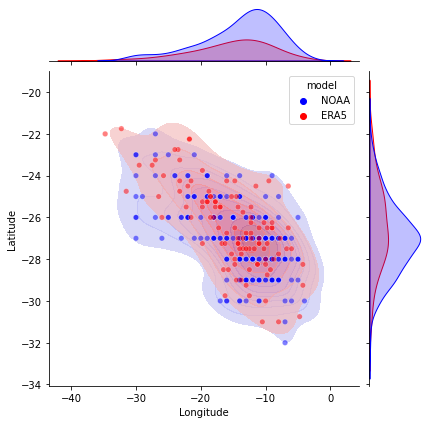

In [28]:
#for index in out:
for index in ['ERA5']:
    if index == 'NOAA':
        pass
    else:
        df  = out['NOAA']
        df['model'] = 'NOAA'
        df2 = out[index]
        df2['model'] = str(index)
        df = df.append(df2)
        g = sns.jointplot(data= df,x='east',y = 'south', hue="model",kind="kde",fill=True,  palette=["blue","red"],joint_kws={'alpha': 0.6} )
        g.plot_joint(sns.scatterplot, s=30, alpha=.5)
        g.ax_joint.set_xlabel('Longitude')
        g.ax_joint.set_ylabel('Latitude')
        plt.savefig('../HIGH_OUT/jointplots/jointplot_'+str(index)+'.png',dpi=100)
        plt.savefig('../HIGH_OUT/jointplots/jointplot_'+str(index)+'.pdf')
        #plt.close()
        plt.show()

In [14]:
NOAA = out['NOAA']
seasons =[]
for i in range(len(NOAA.time)):
    if NOAA.iloc[i].time.month == 12:
        seasons.append('Summer')
    elif NOAA.iloc[i].time.month == 3:
        seasons.append('Autumn')
    elif NOAA.iloc[i].time.month == 6:
        seasons.append('Winter')
    else:
        seasons.append('Spring')


NOAA['Season'] = seasons

In [15]:
NOAA

,time,east,south,pres,model,Season
0,1949-12-01,-11.0,-29.0,1546.673096,NOAA,Summer
1,1950-03-01,-18.0,-26.0,1539.696533,NOAA,Autumn
2,1950-06-01,-27.0,-24.0,1557.934326,NOAA,Winter
3,1950-09-01,-8.0,-27.0,1545.378662,NOAA,Spring
4,1950-12-01,-16.0,-30.0,1554.858643,NOAA,Summer
...,...,...,...,...,...,...
220,2004-12-01,-12.0,-29.0,1552.706909,NOAA,Summer
221,2005-03-01,-14.0,-28.0,1558.829102,NOAA,Autumn
222,2005-06-01,-22.0,-26.0,1568.382690,NOAA,Winter
223,2005-09-01,-11.0,-27.0,1553.906250,NOAA,Spring


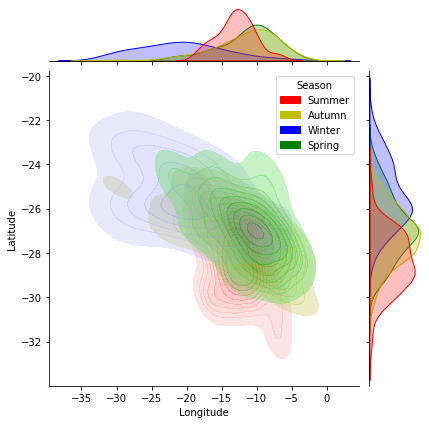

In [16]:
df  = NOAA
g = sns.jointplot(data= df,x='east',y = 'south',hue='Season',kind="kde",fill=True,  palette=['r','y','b','g'],joint_kws={'alpha': 0.35})
g.ax_joint.set_xlabel('Longitude')
g.ax_joint.set_ylabel('Latitude')
#plt.savefig('../HIGH_OUT/NOAA_seasonality_jointplot.png',dpi=1000)
plt.savefig('../HIGH_OUT/NOAA_seasonality_jointplot.pdf')

In [17]:
f = open("../HIGH_OUT/out_dict.txt","w") #ipython pickles cant be read by .py
f.write( str(out) )
f.close()

In [21]:
results_df = pd.DataFrame([],columns=["model", "Mean Latitude" ,"Latitude Difference","Latitude std.","Latitude Range", "Mean Longitude" ,"Longitude Difference" ,"longitude std.", "Longitude Range"])
for index in out:
         results_df.loc[len(results_df)] = [index,round(np.mean(out[index].south),2),round(np.mean(out[index].south-np.mean(out['NOAA'].south)),2), round(np.std(out[index].south),2),round(getrange(out[index].south),2),round(np.mean(out[index].east),2),round(np.mean(out[index].east-np.mean(out['NOAA'].east)),2),round(np.std(out[index].east),2),round(getrange(out[index].east),2)]
    

In [22]:
results_df.to_csv('../HIGH_OUT/results_table.csv',float_format='%.2f')

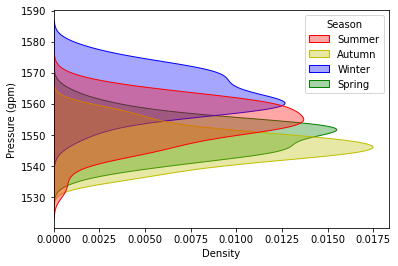

In [23]:
fig = sns.kdeplot(data=NOAA,y='pres',hue='Season',fill=True,alpha=0.35, palette=['r','y','b','g'])
plt.ylabel('Pressure (gpm)')
plt.savefig('../HIGH_OUT/NOAA_seasonality_pressure.png',dpi=1000)
plt.savefig('../HIGH_OUT/NOAA_seasonality_pressure.pdf')

In [24]:
results_df=pd.DataFrame([],columns=('Model','Mean','Difference', 'Std.','Range','Mean', 'Difference', 'Std.','Range','Mean','Difference', 'Std.','Range'))
for index in out.keys():
    results_df.loc[len(results_df)] = [index,round(np.mean(out[index].south),2),round(np.mean(out[index].south-np.mean(out['NOAA'].south)),2), round(np.std(out[index].south),2),round(getrange(out[index].south),2),round(np.mean(out[index].east),2),round(np.mean(out[index].east-np.mean(out['NOAA'].east)),2),round(np.std(out[index].east),2),round(getrange(out[index].east),2),round(np.mean(out[index].pres),2),round(np.mean(out[index].pres-np.mean(out['NOAA'].pres)),2),round(np.std(out[index].pres),2),round(getrange(out[index].pres),2)]


In [26]:
results_df.head()

,Model,Mean,Difference,Std.,Range,Mean,Difference,Std.,Range,Mean,Difference,Std.,Range
0,IPSL-CM5A-LR,-26.49,0.52,2.20,11.37,-22.08,-8.03,8.35,41.25,1546.62,-6.69,10.97,54.59
1,MPI-ESM-MR,-26.67,0.33,2.75,11.19,-20.54,-6.49,12.12,46.88,1558.66,5.36,12.09,59.88
2,MRI-ESM1,-24.14,2.87,2.20,8.97,6.45,20.50,15.09,49.50,1573.27,19.96,13.62,70.92
3,MIROC-ESM-CHEM,-26.19,0.82,2.38,11.16,-19.14,-5.09,9.71,36.56,1563.06,9.75,9.77,61.15
4,EC-EARTH,-26.60,0.41,2.59,10.09,-20.46,-6.42,11.73,45.00,1544.92,-8.39,14.09,62.00


In [25]:
results_df.to_csv('../HIGH_OUT/results_table_1D.csv')